<a href="https://colab.research.google.com/github/Lucas-Masaba/refactory-ml-main/blob/main/GIZ_AI_Skills_kmeans_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'facebook-live-sellers-in-thailand-uci-ml-repo:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F260377%2F545527%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240305%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240305T104609Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D97fb551e0c0729df120f385d7b3ec6d110a40ab41246778571400f6357bf5d3266985b441adc37a8b0deba6d2bcfc314d9da1bfd1e85e721123ec754da3ec11b5f0439c8fa5cb7a912035554b8fe63eebd7ba6d9b8a3d62989cd644f7c8d36cab6c07b2e7240a1b1a3fe113d5f97e2ed832eeae4142c500194c6b2fd2af14dd5bc493e5f0796c70a7470ec732a4536b1a3f3b070f9810099df0760e9d8c93777726f8085765050635373707eddcb5a40026e4ed04858e4615bb03187127c10095ce2b614c449233582da705a71cfddb934154240f9a94b2206fd9bfe276e482517a8455a6d3c2d5f9663314f32db298a6dc5b4e967a0b1961aa2e5beca805528'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 141194 bytes downloaded
Downloaded and uncompressed: facebook-live-sellers-in-thailand-uci-ml-repo
Data source import complete.


In [ ]:
!pwd

/content


In [ ]:
!pip install pandas-profiling

In [ ]:
from ydata_profiling import ProfileReport



<a class="anchor" id="0"></a>
# **K-Means Clustering with Python**



**K-Means clustering** is the most popular unsupervised machine learning algorithm. K-Means clustering is used to find intrinsic groups within the unlabelled dataset and draw inferences from them. In this kernel, I implement K-Means clustering to find intrinsic groups within the dataset that display the same `status_type` behaviour. The `status_type` behaviour variable consists of posts of a different nature (video, photos, statuses and links).


So, let's get started.

<a class="anchor" id="0.1"></a>
# **Table of Contents**


1.	[Introduction to K-Means Clustering](#1)
1.  [Applications of clustering](#2)
1.	[K-Means Clustering intuition](#3)
1.	[Choosing the value of K](#4)
1.	[The elbow method](#5)
1.  [Import libraries](#6)
1.	[Import dataset](#7)
1.	[Exploratory data analysis](#8)
1.	[Declare feature vector and target variable](#9)
1.	[Convert categorical variable into integers](#10)
1.	[Feature scaling](#11)
1.	[K-Means model with two clusters](#12)
1.	[K-Means model parameters study](#13)
1.	[Check quality of weak classification by the model](#14)
1.	[Use elbow method to find optimal number of clusters](#15)
1.	[K-Means model with different clusters](#16)
1.	[Results and conclusion](#17)
1.  [References](#18)


# **1. Introduction to K-Means Clustering** <a class="anchor" id="1"></a>

[Table of Contents](#0.1)


Machine learning algorithms can be broadly classified into two categories - supervised and unsupervised learning. There are other categories also like semi-supervised learning and reinforcement learning. But, most of the algorithms are classified as supervised or unsupervised learning. The difference between them happens because of presence of target variable. In unsupervised learning, there is no target variable. The dataset only has input variables which describe the data. This is called unsupervised learning.

**K-Means clustering** is the most popular unsupervised learning algorithm. It is used when we have unlabelled data which is data without defined categories or groups. The algorithm follows an easy or simple way to classify a given data set through a certain number of clusters, fixed apriori. K-Means algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity.

K-Means clustering can be represented diagrammatically as follows:-


## K-Means

![K-Means](https://miro.medium.com/max/2160/1*tWaaZX75oumVwBMcKN-eHA.png)

# **2. Applications of clustering** <a class="anchor" id="2"></a>

[Table of Contents](#0.1)


- K-Means clustering is the most common unsupervised machine learning algorithm. It is widely used for many applications which include-

  1. Image segmentation

  2. Customer segmentation

  3. Species clustering

  4. Anomaly detection

  5. Clustering languages

# **3. K-Means Clustering intuition** <a class="anchor" id="3"></a>

[Table of Contents](#0.1)


K-Means clustering is used to find intrinsic groups within the unlabelled dataset and draw inferences from them. It is based on centroid-based clustering.


**Centroid** - A centroid is a data point at the centre of a cluster. In centroid-based clustering, clusters are represented by a centroid. It is an iterative algorithm in which the notion of similarity is derived by how close a data point is to the centroid of the cluster.
K-Means clustering works as follows:-
The K-Means clustering algorithm uses an iterative procedure to deliver a final result. The algorithm requires number of clusters K and the data set as input. The data set is a collection of features for each data point. The algorithm starts with initial estimates for the K centroids. The algorithm then iterates between two steps:-


## **3.1 Data assignment step**


Each centroid defines one of the clusters. In this step, each data point is assigned to its nearest centroid, which is based on the squared Euclidean distance. So, if ci is the collection of centroids in set C, then each data point is assigned to a cluster based on minimum Euclidean distance.



## **3.2 Centroid update step**


In this step, the centroids are recomputed and updated. This is done by taking the mean of all data points assigned to that centroid’s cluster.


The algorithm then iterates between step 1 and step 2 until a stopping criteria is met. Stopping criteria means no data points change the clusters, the sum of the distances is minimized or some maximum number of iterations is reached.
This algorithm is guaranteed to converge to a result. The result may be a local optimum meaning that assessing more than one run of the algorithm with randomized starting centroids may give a better outcome.

The K-Means intuition can be represented with the help of following diagram:-


## K-Means intuition
![K-Means intuition](https://i.ytimg.com/vi/_aWzGGNrcic/hqdefault.jpg)

# **4. Choosing the value of K** <a class="anchor" id="4"></a>

[Table of Contents](#0.1)


The K-Means algorithm depends upon finding the number of clusters and data labels for a pre-defined value of K. To find the number of clusters in the data, we need to run the K-Means clustering algorithm for different values of K and compare the results. So, the performance of K-Means algorithm depends upon the value of K. We should choose the optimal value of K that gives us best performance. There are different techniques available to find the optimal value of K. The most common technique is the **elbow method** which is described below.


# **5. The elbow method** <a class="anchor" id="5"></a>

[Table of Contents](#0.1)


The elbow method is used to determine the optimal number of clusters in K-means clustering. The elbow method plots the value of the cost function produced by different values of K. The below diagram shows how the elbow method works:-

## The elbow method

![Elbow method in K-Means](https://www.oreilly.com/api/v2/epubs/9781788295758/files/assets/995b8b58-06f1-4884-a2a1-f3648428e947.png)

We can see that if K increases, average distortion will decrease.  Then each cluster will have fewer constituent instances, and the instances will be closer to their respective centroids. However, the improvements in average distortion will decline as K increases. The value of K at which improvement in distortion declines the most is called the elbow, at which we should stop dividing the data into further clusters.


# **6. Import libraries** <a class="anchor" id="6"></a>

[Table of Contents](#0.1)


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


/kaggle/input/facebook-live-sellers-in-thailand-uci-ml-repo/Live.csv


### Ignore warnings


In [ ]:
import warnings

warnings.filterwarnings('ignore')

# **7. Import dataset** <a class="anchor" id="7"></a>

[Table of Contents](#0.1)



In [ ]:
data = '/kaggle/input/facebook-live-sellers-in-thailand-uci-ml-repo/Live.csv'

df = pd.read_csv(data)
df.head()

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,246675545449582_1649696485147474,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,246675545449582_1649426988507757,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,246675545449582_1648730588577397,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,246675545449582_1648576705259452,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,246675545449582_1645700502213739,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN


# **8. Exploratory data analysis** <a class="anchor" id="8"></a>

[Table of Contents](#0.1)


### Check shape of the dataset

In [ ]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Profiling Report")


In [ ]:
df.shape

(7050, 16)

We can see that there are 7050 instances and 16 attributes in the dataset. In the dataset description, it is given that there are 7051 instances and 12 attributes in the dataset.

So, we can infer that the first instance is the row header and there are 4 extra attributes in the dataset. Next, we should take a look at the dataset to gain more insight about it.

### Preview the dataset

In [ ]:
df.head()

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,246675545449582_1649696485147474,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,246675545449582_1649426988507757,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,246675545449582_1648730588577397,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,246675545449582_1648576705259452,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,246675545449582_1645700502213739,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN


### View summary of dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   status_id         7050 non-null   object 
 1   status_type       7050 non-null   object 
 2   status_published  7050 non-null   object 
 3   num_reactions     7050 non-null   int64  
 4   num_comments      7050 non-null   int64  
 5   num_shares        7050 non-null   int64  
 6   num_likes         7050 non-null   int64  
 7   num_loves         7050 non-null   int64  
 8   num_wows          7050 non-null   int64  
 9   num_hahas         7050 non-null   int64  
 10  num_sads          7050 non-null   int64  
 11  num_angrys        7050 non-null   int64  
 12  Column1           0 non-null      float64
 13  Column2           0 non-null      float64
 14  Column3           0 non-null      float64
 15  Column4           0 non-null      float64
dtypes: float64(4), int64(9), object(3)
memory 

### Check for missing values in dataset

In [ ]:
df.isnull().sum()

status_id              0
status_type            0
status_published       0
num_reactions          0
num_comments           0
num_shares             0
num_likes              0
num_loves              0
num_wows               0
num_hahas              0
num_sads               0
num_angrys             0
Column1             7050
Column2             7050
Column3             7050
Column4             7050
dtype: int64

We can see that there are 4 redundant columns in the dataset. We should drop them before proceeding further.

### Drop redundant columns

In [ ]:
df.drop(['Column1', 'Column2', 'Column3', 'Column4'], axis=1, inplace=True)

### Again view summary of dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   status_id         7050 non-null   object
 1   status_type       7050 non-null   object
 2   status_published  7050 non-null   object
 3   num_reactions     7050 non-null   int64 
 4   num_comments      7050 non-null   int64 
 5   num_shares        7050 non-null   int64 
 6   num_likes         7050 non-null   int64 
 7   num_loves         7050 non-null   int64 
 8   num_wows          7050 non-null   int64 
 9   num_hahas         7050 non-null   int64 
 10  num_sads          7050 non-null   int64 
 11  num_angrys        7050 non-null   int64 
dtypes: int64(9), object(3)
memory usage: 661.1+ KB


Now, we can see that redundant columns have been removed from the dataset.

We can see that, there are 3 character variables (data type = object) and remaining 9 numerical variables (data type = int64).


### View the statistical summary of numerical variables

In [ ]:
df.describe()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
count,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000
mean,230.117163,224.356028,40.022553,215.043121,12.728652,1.289362,0.696454,0.243688,0.113191
std,462.625309,889.636820,131.599965,449.472357,39.972930,8.719650,3.957183,1.597156,0.726812
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,59.500000,4.000000,0.000000,58.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,219.000000,23.000000,4.000000,184.750000,3.000000,0.000000,0.000000,0.000000,0.000000
max,4710.000000,20990.000000,3424.000000,4710.000000,657.000000,278.000000,157.000000,51.000000,31.000000


There are 3 categorical variables in the dataset. I will explore them one by one.

### Explore `status_id` variable

In [ ]:
# view the labels in the variable

df['status_id'].unique()

array(['246675545449582_1649696485147474',
       '246675545449582_1649426988507757',
       '246675545449582_1648730588577397', ...,
       '1050855161656896_1060126464063099',
       '1050855161656896_1058663487542730',
       '1050855161656896_1050858841656528'], dtype=object)

In [ ]:
# view how many different types of variables are there

len(df['status_id'].unique())

6997

We can see that there are 6997 unique labels in the `status_id` variable. The total number of instances in the dataset is 7050. So, it is approximately a unique identifier for each of the instances. Thus this is not a variable that we can use. Hence, I will drop it.

### Explore `status_published` variable

In [ ]:
# view the unique values in the column status_published

df['status_published'].unique()

array(['4/22/2018 6:00', '4/21/2018 22:45', '4/21/2018 6:17', ...,
       '9/21/2016 23:03', '9/20/2016 0:43', '9/10/2016 10:30'],
      dtype=object)

In [ ]:
# view how many different types of values are there

len(df['status_published'].unique())

6913

Again, we can see that there are 6913 unique labels in the `status_published` variable. The total number of instances in the dataset is 7050. So, it is also a approximately a unique identifier for each of the instances. Thus this is not a variable that we can use. Hence, I will drop it also.

### Explore `status_type` variable

In [ ]:
# view the labels in the variable

df['status_type'].unique()

array(['video', 'photo', 'link', 'status'], dtype=object)

In [ ]:
# view how many different types of variables are there

len(df['status_type'].unique())

4

We can see that there are 4 categories of labels in the `status_type` variable.

### Drop `status_id` and `status_published` variable from the dataset

In [ ]:
df.drop(['status_id', 'status_published'], axis=1, inplace=True)

### View the summary of dataset again

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   status_type    7050 non-null   object
 1   num_reactions  7050 non-null   int64 
 2   num_comments   7050 non-null   int64 
 3   num_shares     7050 non-null   int64 
 4   num_likes      7050 non-null   int64 
 5   num_loves      7050 non-null   int64 
 6   num_wows       7050 non-null   int64 
 7   num_hahas      7050 non-null   int64 
 8   num_sads       7050 non-null   int64 
 9   num_angrys     7050 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 550.9+ KB


### Preview the dataset again

In [ ]:
df.head()

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,video,529,512,262,432,92,3,1,1,0
1,photo,150,0,0,150,0,0,0,0,0
2,video,227,236,57,204,21,1,1,0,0
3,photo,111,0,0,111,0,0,0,0,0
4,photo,213,0,0,204,9,0,0,0,0


We can see that there is 1 non-numeric column `status_type` in the dataset. I will convert it into integer equivalents.

# **9. Declare feature vector and target variable** <a class="anchor" id="9"></a>

[Table of Contents](#0.1)


In [ ]:
X = df

y = df['status_type']

# **10. Convert categorical variable into integers** <a class="anchor" id="10"></a>

[Table of Contents](#0.1)


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X['status_type'] = le.fit_transform(X['status_type'])

y = le.transform(y)

### View the summary of X

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   status_type    7050 non-null   int64
 1   num_reactions  7050 non-null   int64
 2   num_comments   7050 non-null   int64
 3   num_shares     7050 non-null   int64
 4   num_likes      7050 non-null   int64
 5   num_loves      7050 non-null   int64
 6   num_wows       7050 non-null   int64
 7   num_hahas      7050 non-null   int64
 8   num_sads       7050 non-null   int64
 9   num_angrys     7050 non-null   int64
dtypes: int64(10)
memory usage: 550.9 KB


### Preview the dataset X

In [ ]:
X.head()

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,3,529,512,262,432,92,3,1,1,0
1,1,150,0,0,150,0,0,0,0,0
2,3,227,236,57,204,21,1,1,0,0
3,1,111,0,0,111,0,0,0,0,0
4,1,213,0,0,204,9,0,0,0,0


# **11. Feature Scaling** <a class="anchor" id="11"></a>

[Table of Contents](#0.1)

In [ ]:
cols = X.columns

In [ ]:
from sklearn.preprocessing import MinMaxScaler

ms = MinMaxScaler()

X = ms.fit_transform(X)

In [ ]:
X = pd.DataFrame(X, columns=[cols])

In [ ]:
X.head()

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,1.000000,0.112314,0.024393,0.076519,0.091720,0.140030,0.010791,0.006369,0.019608,0.0
1,0.333333,0.031847,0.000000,0.000000,0.031847,0.000000,0.000000,0.000000,0.000000,0.0
2,1.000000,0.048195,0.011243,0.016647,0.043312,0.031963,0.003597,0.006369,0.000000,0.0
3,0.333333,0.023567,0.000000,0.000000,0.023567,0.000000,0.000000,0.000000,0.000000,0.0
4,0.333333,0.045223,0.000000,0.000000,0.043312,0.013699,0.000000,0.000000,0.000000,0.0


### You can drop the status_type here if you need to

In [ ]:
#Drop status type from X
# X.drop(['status_type'], axis=1, inplace=True)

In [ ]:
X.columns

MultiIndex([(  'status_type',),
            ('num_reactions',),
            ( 'num_comments',),
            (   'num_shares',),
            (    'num_likes',),
            (    'num_loves',),
            (     'num_wows',),
            (    'num_hahas',),
            (     'num_sads',),
            (   'num_angrys',)],
           )

# **12. K-Means model with two clusters** <a class="anchor" id="12"></a>

[Table of Contents](#0.1)

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0)

kmeans.fit(X)

KMeans(n_clusters=2, random_state=0)

# **13. K-Means model parameters study** <a class="anchor" id="13"></a>

[Table of Contents](#0.1)

In [ ]:
kmeans.cluster_centers_

array([[3.28506857e-01, 3.90710874e-02, 7.54854864e-04, 7.53667113e-04,
        3.85438884e-02, 2.17448568e-03, 2.43721364e-03, 1.20039760e-03,
        2.75348016e-03, 1.45313276e-03],
       [9.54921576e-01, 6.46330441e-02, 2.67028654e-02, 2.93171709e-02,
        5.71231462e-02, 4.71007076e-02, 8.18581889e-03, 9.65207685e-03,
        8.04219428e-03, 7.19501847e-03]])

- The KMeans algorithm clusters data by trying to separate samples in n groups of equal variances, minimizing a criterion known as **inertia**, or within-cluster sum-of-squares Inertia, or the within-cluster sum of squares criterion, can be recognized as a measure of how internally coherent clusters are.


- The k-means algorithm divides a set of N samples X into K disjoint clusters C, each described by the mean j of the samples in the cluster. The means are commonly called the cluster **centroids**.


- The K-means algorithm aims to choose centroids that minimize the inertia, or within-cluster sum of squared criterion.

### Inertia


- **Inertia** is not a normalized metric.

- The lower values of inertia are better and zero is optimal.

- But in very high-dimensional spaces, euclidean distances tend to become inflated (this is an instance of `curse of dimensionality`).

- Running a dimensionality reduction algorithm such as PCA prior to k-means clustering can alleviate this problem and speed up the computations.

- We can calculate model inertia as follows:-

In [ ]:
kmeans.inertia_

237.75726404419646

- The lesser the model inertia, the better the model fit.

- We can see that the model has very high inertia. So, this is not a good model fit to the data.

 # **14. Check quality of weak classification by the model** <a class="anchor" id="14"></a>

[Table of Contents](#0.1)

In [ ]:
labels = kmeans.labels_

# check how many of the samples were correctly labeled
correct_labels = sum(y == labels)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))


Result: 63 out of 7050 samples were correctly labeled.


In [ ]:
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Accuracy score: 0.01


We have achieved a weak classification accuracy of 1% by our unsupervised model.

# **15. Use elbow method to find optimal number of clusters** <a class="anchor" id="15"></a>

[Table of Contents](#0.1)

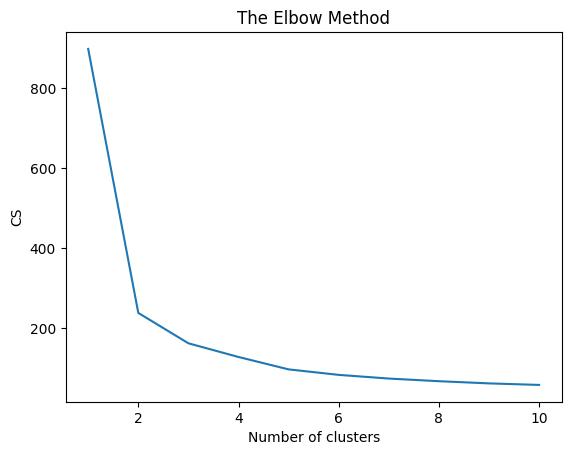

In [ ]:
from sklearn.cluster import KMeans
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()


- By the above plot, we can see that there is a kink at k=2.

- Hence k=2 can be considered a good number of the cluster to cluster this data.

- But, we have seen that I have achieved a weak classification accuracy of 4% with k=2.

- Here is the code with k=2 again for convinience.

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2,random_state=0)

kmeans.fit(X)

labels = kmeans.labels_

# check how many of the samples were correctly labeled

correct_labels = sum(y == labels)

print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))

print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Result: 275 out of 7050 samples were correctly labeled.
Accuracy score: 0.04


So, our weak unsupervised classification model achieved a very weak classification accuracy of 1%.

I will check the model accuracy with different number of clusters.

# **16. K-Means model with different clusters** <a class="anchor" id="16"></a>

[Table of Contents](#0.1)

### K-Means model with 3 clusters

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0)

kmeans.fit(X)

# check how many of the samples were correctly labeled
labels = kmeans.labels_

correct_labels = sum(y == labels)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Result: 138 out of 7050 samples were correctly labeled.
Accuracy score: 0.02


### K-Means model with 4 clusters

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)

kmeans.fit(X)

# check how many of the samples were correctly labeled
labels = kmeans.labels_

correct_labels = sum(y == labels)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Result: 4340 out of 7050 samples were correctly labeled.
Accuracy score: 0.62


We have improved the clustering accuracy to 16%



Algorithm for cluster number selection:
Determining the elbow point in the SSE curve isn’t always straightforward. If you’re having trouble choosing the elbow point of the curve, then you could use a Python package, **kneed**, to identify the elbow point programmatically:


In [ ]:
!pip install kneed[plot]

In [ ]:
from kneed import KneeLocator
kmeans_kwargs = {
     "init": "random",
     "n_init": 10,
      "max_iter": 300,
      "random_state": 0,
 }

sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(X)
  sse.append(kmeans.inertia_)

kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing"
 )
kl.elbow

2

The kneed library recommends a cluster size of 3.

**BONUS section:**

Just for fun, let's try to push this even farther. We can use the t-distributed stochastic neighbor embedding (t-SNE) algorithm  to pre-process the data before performing k-means. t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters. Let's see how it does:

In [ ]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
X_proj = tsne.fit_transform(X)

# Compute the clusters
kmeans = KMeans(n_clusters=4, random_state=0)

kmeans.fit(X_proj)

# check how many of the samples were correctly labeled
labels = kmeans.labels_

correct_labels = sum(y == labels)
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
print('Accuracy score: {0:0.2f}'. format(correct_labels/float(y.size)))

Result: 1767 out of 7050 samples were correctly labeled.
Accuracy score: 0.25


We already observe a significant improvement in the clustering performance

## Visualization

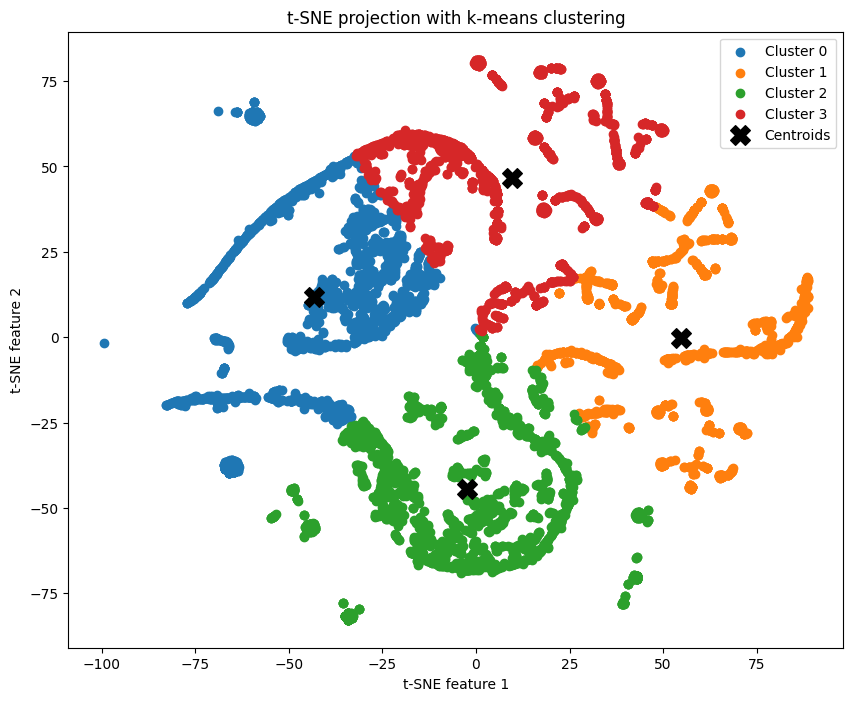

In [ ]:
# Obtain the cluster labels
labels = kmeans.labels_

# Plot the projected data with cluster labels
plt.figure(figsize=(10, 8))
unique_labels = np.unique(labels)
for label in unique_labels:
    plt.scatter(X_proj[labels == label, 0], X_proj[labels == label, 1], label=f'Cluster {label}')

# Plot centroids
centroids_proj = kmeans.cluster_centers_
plt.scatter(centroids_proj[:, 0], centroids_proj[:, 1], marker='X', s=200, color='k', label='Centroids')

plt.title('t-SNE projection with k-means clustering')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend()
plt.show()


# **17. Results and conclusion** <a class="anchor" id="17"></a>

[Table of Contents](#0.1)


1.	In this project, we have implemented the most popular unsupervised clustering technique called **K-Means Clustering**.

2.	We have applied the elbow method and find that k=2 (k is number of clusters) can be considered a good number of cluster to cluster this data.

3.	We have demonstrated the impact of the number of clusters when using this as a weak classifier


Some potential cluster interpretations:
- **High Engagement Posts**: Clusters characterized by high numbers of reactions, comments, and shares. These posts are likely successful in eliciting a strong response from the audience.

- **Content-Specific Clusters**: Clusters that might correspond to specific types of content (e.g., videos, photos) with distinct engagement patterns. For instance, video posts might generally receive more engagement in certain metrics compared to photo posts.

- **Emotional Response Groups**: Clusters might differentiate posts based on the type of emotional reaction they primarily evoke (more loves, laughs, sadness, or anger), providing insights into the emotional impact of different types of content.

- **Low Engagement Posts**: Clusters with lower overall engagement, indicating content that fails to resonate with the audience or is less visible.

# **18. References** <a class="anchor" id="18"></a>

[Table of Contents](#0.1)

The work done in this project is inspired from following books and websites:-

  1. Udemy course – Machine Learning – A Z by Kirill Eremenko and Hadelin de Ponteves

  2. https://en.wikipedia.org/wiki/K-means_clustering

  3. https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

  4. https://www.datacamp.com/community/tutorials/k-means-clustering-python

  5. https://www.datascience.com/blog/k-means-clustering

  6. https://acadgild.com/blog/k-means-clustering-algorithm



**Exercises:**

i. Repeat the EDA for analysis above using the pandas profiling package

ii. Check the impact of the performance of your clustering if you retain the "status_type" column. How does you weak classifier perform with and without this column. Do you think it is a good idea to keep it?
Hint: Remember, the decision to include or exclude the status_type column should align with your analysis goals. If the content type is not relevant to your clustering objective, removing it can simplify the model and focus the analysis on engagement metrics alone.

iii. Select different hyper parameters for the kMeans algorithm and improve the performance of the model

iv. Carry out a qualitative analysis of the model? Does the clustering work as you expect. Hint: Sample a few points from the dataset and see what cluster they are assigned to and if it makes sense given your knowledge of the ground truth.

iv. What is the impact of the scaling on the performance of the clustering algorithm?

V. Repeat the visualization, this time with PCA

[Go to Top](#0)